In [424]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy


![alt text](map.jpg "Схема GPS")

# Агрохимия 

In [368]:
agrochemistry_total = pd.read_csv('полевые данные общая/ready_data/агрохимия.csv')
agrochemistry_total["Год"] = agrochemistry_total["Год"].astype(str)
agrochemistry_total["GPS №"] = agrochemistry_total["GPS №"].astype(str)
agrochemistry_total.columns

Index(['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Общий углерод, %',
       'М.д. содержания  гипса (по Хитрову), %',
       'Массовая доля иона хлорида, ммоль/100 г',
       'Массовая доля иона сульфата, ммоль/100 г',
       'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
       'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
       'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы',
       'Сумма поглощенных оснований по Каппену, ммоль/100 г',
       'Массовая доля плотного остатка водной вытяжки, %',
       'Карбонат и бикарбонат-ионы, ммоль/100 г',
       'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
       'Массовая доля общего содержания карб

### Агрохимические показатели по пахатному горизонту

In [553]:
agrochem_columns = ['Год', 'GPS №', 'Тип обработки', 'Глубина', 'повторность',
       'рН солевой вытяжки, ед. рН', 'рН водной вытяжки, ед. рН',
       'Фосфор (подвижная форма), мг/кг', 'Калий (подвижная форма), млн-1',
       'Общий азот, %', 'Органический углерод, %']


agrochemistry_main = agrochemistry_total[agrochemistry_total['Глубина'].isin(['0-10',"10-20","20-30"])][agrochem_columns]
agrochemistry_main['GPS №'] = agrochemistry_main['GPS №'].astype(int)
agrochemistry_main.drop('повторность', axis = 1, inplace= True)
agrochemistry_main.dropna(axis = 0, inplace= True)





In [555]:

def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property_ = re.sub(r'[\(),.%№ /-]', '' , agrochem_property)
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '', )
    reg = ols('{} ~ Год + Глубина  +  Типобработки + GPS'.format(agrochem_property_) ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

def anova(df, varible, agrochem_property):
    stat_test_df = pd.DataFrame()
    for ind,depth in enumerate(df["Глубина"].unique()): 
        df_by_depth = df[df["Глубина"] == depth]
        sample_list = []
        for value  in df[varible].unique():
            sample = df_by_depth[agrochem_property][df[varible] == value].values
            sample_list.append(sample) 
        
        p_val = ANOVA(*sample_list)[1]
        local_df = pd.DataFrame({"глубина":depth, 'p-value' : p_val}, index = [ind])
        stat_test_df = stat_test_df.append(local_df)
    stat_test_df["p-value"] = round(stat_test_df["p-value"],3)
    return(stat_test_df)
    
def ploting( df, hue,  agrochem_property , aov ,stat_test_df, to_lable = "по обработкам" ):
    fig = plt.figure(figsize=(7,7))
    ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan = 2)
    ax2 = plt.subplot2grid((3,2), (2, 0))
    ax3 = plt.subplot2grid((3,2), (2, 1))
    if len(df[hue].unique()) == 2:
        pal =  "prism_r"
    else:
        pal =  "tab10"
    sns.pointplot(data = df,
        x = "Глубина",
        y = agrochem_property,
        hue = hue,
        palette = pal,
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
        ax = ax1)
    ax1.set_title('Сравнение по {}'.format(to_lable))

    ax2.axis('off')
    ax2.axis('tight')
    ax2.table(aov.values,rowLabels=aov.index , colLabels = aov.columns ,loc='center')
    ax2.set_title('Дисперсионный анализ \nпо {} (MANOVA)'.format(to_lable),  y=0.75 , x = 0.5)

    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(stat_test_df.values, colLabels = stat_test_df.columns ,loc='center')
    ax3.set_title('Сравнение выборок \nпо {} (ANOVA)'.format(to_lable),  y=0.75 , x = 0.5)
    plt.show(block=True)
    return fig 

def data_processing(df, type_ , agrochem_property , to_lable = "1", fizika = None ):
    stats_type = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})
    if fizika == None:
        features = ['Год', 'GPS №', 'Тип обработки', 'Глубина']
    else:
        features = ['GPS №']
    features.append(agrochem_property) #добавление фичи
    df = df[features]
    stats = df.groupby([type_,'Глубина']).agg({ np.mean,  np.std, scipy.stats.variation})

    aov = aov_for_nominal(df, agrochem_property)
    stat_test_df = anova(df, type_, agrochem_property)
    fig = ploting(df, type_, agrochem_property, aov,stat_test_df,to_lable  )

    return(stats , aov, stat_test_df,fig )


#### отобрали данные

описательные статистики

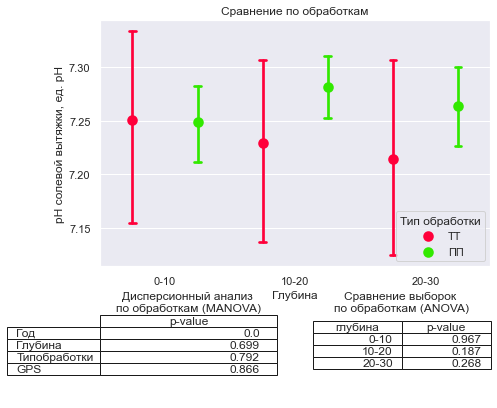

In [556]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

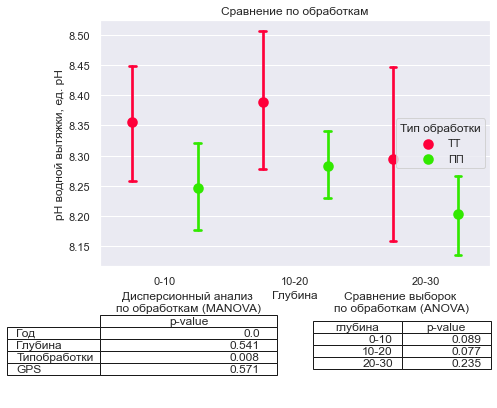

In [557]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

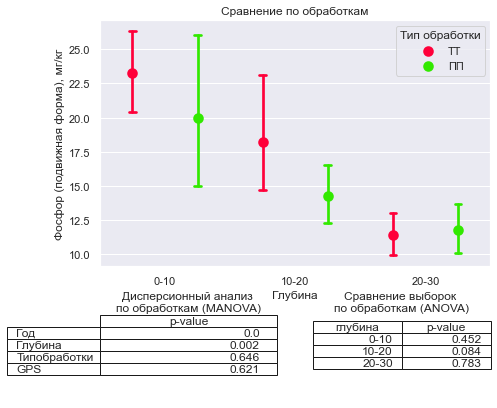

In [558]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

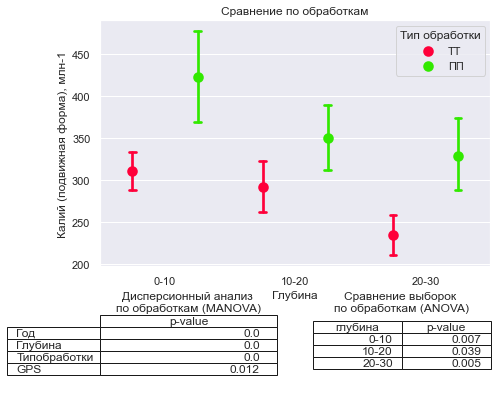

In [559]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

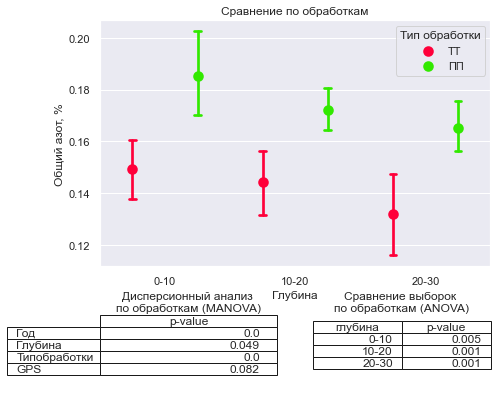

In [560]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Общий азот, %', to_lable = "обработкам")

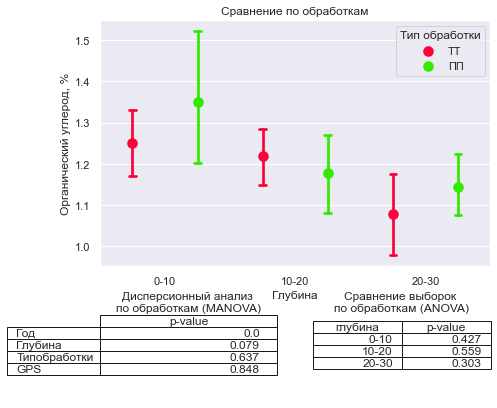

In [561]:
_,_,_ ,fig = data_processing(df = agrochemistry_main, type_ = 'Тип обработки', agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

In [565]:
pp_points = [525,526,527,528,586]
by_points = agrochemistry_main[agrochemistry_main["GPS №"].isin(pp_points)]

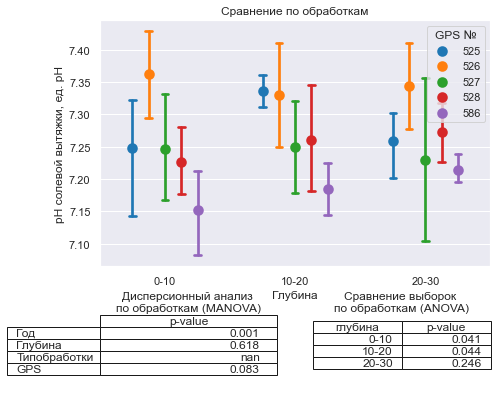

In [566]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН солевой вытяжки, ед. рН', to_lable = "обработкам")

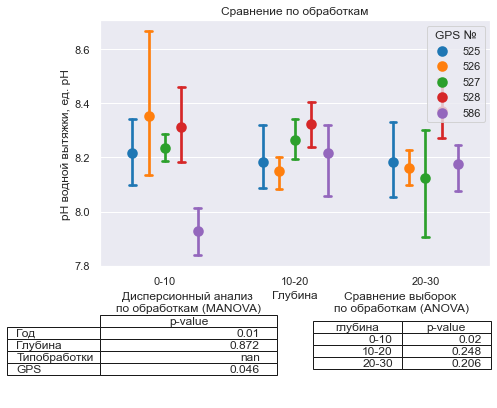

In [567]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'рН водной вытяжки, ед. рН', to_lable = "обработкам")

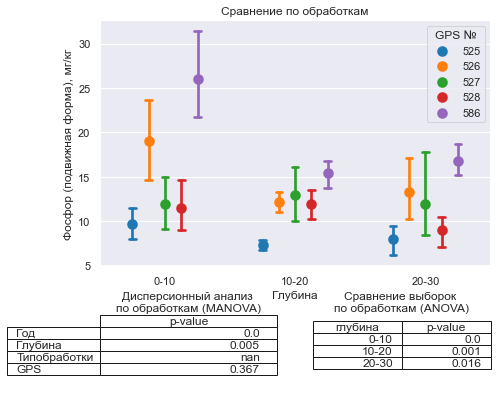

In [568]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Фосфор (подвижная форма), мг/кг', to_lable = "обработкам")

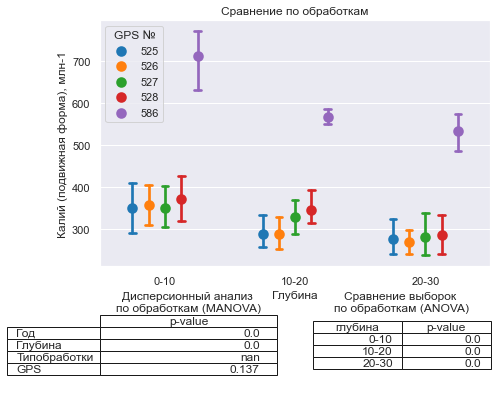

In [569]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Калий (подвижная форма), млн-1', to_lable = "обработкам")

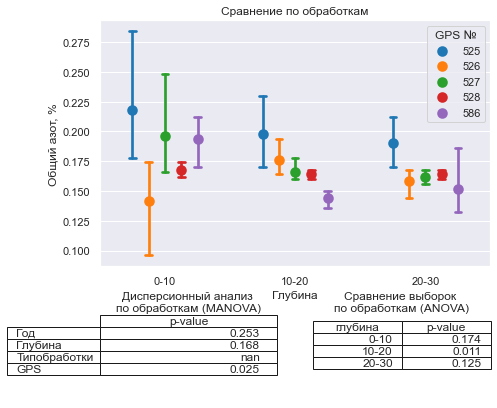

In [570]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Общий азот, %', to_lable = "обработкам")

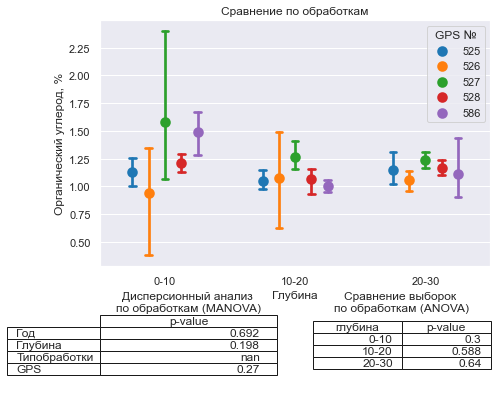

In [571]:
_,_,_ ,fig = data_processing(df = by_points, type_ = "GPS №", agrochem_property = 'Органический углерод, %', to_lable = "обработкам")

получилось все сделать тут надо допилить фоном обеспеченность 

Почвенные профили - код готов следующее это посмотреть в учебнике на работе какие профили надо использовать 

In [460]:

horizonts = ['A',"B" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]
def profile_plot(sample,plot_name , horizonts = None,depth = None, colors = None, ):
    agrochem_features =[
    'Сумма поглощенных оснований по Каппену, ммоль/100 г',  
    'рН солевой вытяжки, ед. рН',
    'рН водной вытяжки, ед. рН', 
    'М.д. содержания  гипса (по Хитрову), %',
    'Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)',
    'Органический углерод, %'
    ]

    agrochem_features_labs = [
        "СПО, ммоль/100 г",
        'рН сол.',
        'рН вод.',
        "Гипс, %",
        "Карботнаты, %",
        "Орг. Углерод, %" ]
    limits = [
        (0,30),
        (6,8.5),
        (6,9.5),
        (0,9), 
        (0,5),
        (0,2)

    ]

    plot_num = len(agrochem_features)
    sizes = [1] * plot_num
    sizes.append( 0.5)
    hr = {'height_ratios': sizes}
    fig, ax  = plt.subplots(plot_num + 1,1, figsize = (10,plot_num * 2), gridspec_kw=hr )

    sns.lineplot(data =sample, y ='Органический углерод, %' , x = "depth" ,alpha = 0,ci=None, ax = ax[-1])
    ax[-1].set( ylabel ='Горизонт', yticks =[]  )
    ax[-1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[-1].set_xlabel('глубина', rotation = 180)
    ax[-1].set_title('№ скважины {}'.format(plot_name), fontsize = 16, rotation = 90, x = -0.1, y = 2)

    if horizonts != None:
        for hor in range(len(horizonts)):
            ax[-1].fill_between(x =depth[hor],y1 = 2, color=colors[hor], alpha=0.7)
            text_position = (depth[hor][1] - depth[hor][0])/2 + depth[hor][0]
            ax[-1].text(x = text_position , y = 0.6, s = horizonts[hor],size = 16,weight='bold' , rotation = 90)


    for num, prop in enumerate(agrochem_features):

        property = gaussian_filter1d(sample[prop].astype('float'), sigma = 1)
        sns.lineplot(y = property , x = sample["depth"] ,color = 'black', ci=None, ax = ax[num])
        ax[num].set(xticks=[], xlabel=None, ylabel =agrochem_features_labs[num] , ylim=limits[num])
        ax[num].set_yticklabels(ax[num].get_yticks(), rotation = 90)
        if horizonts != None:
            for line in depth:
                ax[num].axvline(line[1],color =  "black", alpha = 0.5, linestyle = "--")







In [461]:
sample['Сумма поглощенных оснований по Каппену, ммоль/100 г'].astype('float')

72    22.700000
73    24.200000
74    24.400000
75    24.700000
76    24.716981
77    24.528302
78    23.900000
79    23.900000
80    22.169811
81    24.622642
82    24.339623
83    24.528302
84    24.433962
85    24.433962
86    24.528302
87    24.339623
88    24.400000
89    24.716981
90    24.622642
91    24.622642
Name: Сумма поглощенных оснований по Каппену, ммоль/100 г, dtype: float64

In [462]:
sample = agrochemistry_total[agrochemistry_total["GPS №"] == '525']
sample = sample[sample['повторность'] == '[0]']
sample['depth'] = sample["Глубина"].str.split('-', expand=True)[0]
sample['depth'] = sample['depth'].astype(int)
sample = sample.round(2)
sample = sample.drop('Массовая доля общего содержания карбонатов (по Козловскому), %(CaCO3)', axis = 1)
sample = sample.dropna(axis = 0)
sample


,Год,GPS №,Тип обработки,Глубина,повторность,"рН солевой вытяжки, ед. рН","рН водной вытяжки, ед. рН","Фосфор (подвижная форма), мг/кг","Калий (подвижная форма), млн-1","Общий азот, %",...,"Массовая доля магния (водорастворимая форма), ммоль/100 г почвы","Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы","Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы","Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы","Сумма поглощенных оснований по Каппену, ммоль/100 г","Массовая доля плотного остатка водной вытяжки, %","Карбонат и бикарбонат-ионы, ммоль/100 г","Массовая доля общего содержания карбонатов (по Козловскому), % (CO2)","Органический углерод, %",depth
72,2020,525,ПП,0-10,[0],7.33,8.45,7.48,459.78,0.34,...,0.20,0.80,0.04,0.08,22.7,0.57,0.65,1.10,1.19,0
73,2020,525,ПП,10-20,[0],7.30,8.43,6.32,375.72,0.26,...,0.00,0.80,0.03,0.05,24.2,0.11,0.70,1.58,0.93,10
74,2020,525,ПП,20-30,[0],7.31,8.45,4.35,371.96,0.23,...,1.35,0.70,0.03,0.04,24.4,0.11,0.65,1.28,1.02,20
75,2020,525,ПП,30-40,[0],7.32,8.46,4.35,257.63,0.17,...,0.40,0.55,0.04,0.02,24.700000000000003,0.09,0.60,1.80,1.30,30
76,2020,525,ПП,40-50,[0],7.33,8.50,6.32,225.73,0.11,...,0.20,0.65,0.05,0.02,24.71698113207547,0.12,0.75,2.38,1.23,40
77,2020,525,ПП,50-60,[0],7.33,8.54,5.83,198.74,0.11,...,0.85,0.75,0.05,0.02,24.528301886792455,0.35,0.80,2.67,1.08,50
78,2020,525,ПП,60-70,[0],7.42,8.56,7.31,194.22,0.09,...,0.50,0.50,0.05,0.01,23.9,0.21,0.65,2.68,1.03,60
79,2020,525,ПП,70-80,[0],7.41,8.58,7.80,198.25,0.09,...,0.50,0.48,0.06,0.02,23.9,0.23,0.80,2.16,1.18,70
80,2020,525,ПП,80-90,[0],7.41,8.64,7.80,192.14,0.05,...,0.95,0.40,0.07,0.01,22.16981132075472,0.17,0.70,3.43,0.88,80
81,2020,525,ПП,90-100,[0],7.57,8.87,9.28,190.80,0.04,...,0.55,0.40,0.09,0.02,24.62264150943397,0.11,0.75,5.46,0.40,90


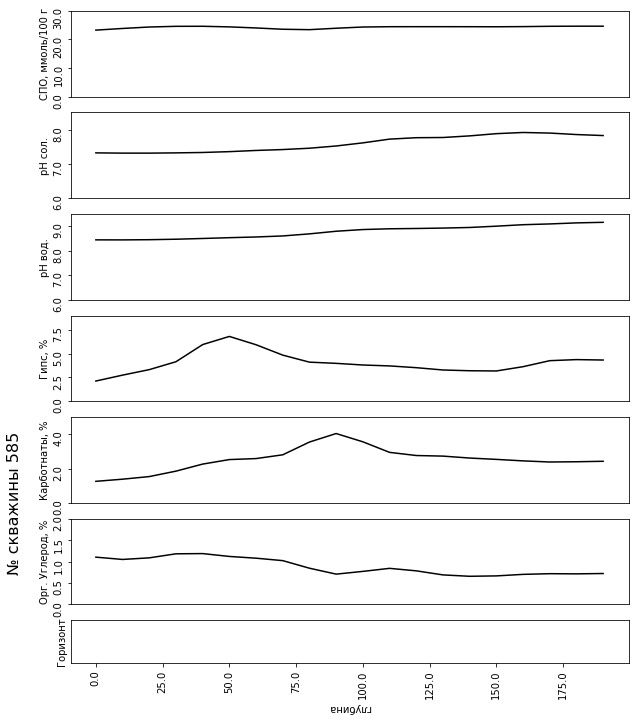

In [463]:

horizonts = ['A',"Bc" , "C"]
depth = [[0,35],[35,100], [100 ,175]]
colors = ["#6E2C00","#BF7F50", "#FFDF29"]

profile_plot(sample,'585'  )

In [464]:
def salt_profile(sample):    
    kations = ['Массовая доля кальция (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля магния (водорастворимая форма), ммоль/100 г почвы',
        'Массовая доля натрия (водорастворимая форма), мг•экв на 100 г почвы',
        'Массовая доля калия (водорастворимая форма), мг•экв на 100 г почвы'
    ]
    anions = ['Карбонат и бикарбонат-ионы, ммоль/100 г', 
        'Массовая доля иона хлорида, ммоль/100 г',
        'Массовая доля иона сульфата, ммоль/100 г'
    ]
    sample[anions] = sample[anions] * -1 


    anions.extend(kations)
    salts = anions.copy()
    anions.extend(["Массовая доля плотного остатка водной вытяжки, %", "depth"])
    salt_sample = sample[anions]

    colors = ['#FF0000', "#FFF300", "#13FF00", "#00FFFB","#0000FF","#C500FF", "#FF0068" ]
    labs = ["CO\u2083\u00B2\u207B и HCO\u2083\u207B" , 
    "Cl\u207B",
    "SO\u2084\u00B2\u207B",
    "Ca\u00B2\u207A",
    "Mg\u00B2\u207A",
    "Na\u207A",
    "K\u207A"]
    legend_list = []
    for i in range(len(labs)):
        legend_list.append(mpatches.Patch(color=colors[i], label= labs[i],alpha=0.5))

    hr = {'height_ratios': [ 2,4]}
    fig, ax  = plt.subplots(2,1, figsize = (10,6), gridspec_kw=hr )

    sns.lineplot(y =gaussian_filter1d(salt_sample["Массовая доля плотного остатка водной вытяжки, %"], sigma = 1) , x = salt_sample["depth"], color = 'black' ,ci=None, ax = ax[0])
    ax[0].invert_xaxis()
    ax[0].set(xticks=[], xlabel=None, ylabel ='Плотн.ост, %' )
    ax[0].set(ylim=(0, 2), label = '')
    ax[0].set_yticklabels(ax[0].get_yticks(), rotation = 90)


    for num, sal in enumerate(salts):
        sns.lineplot( y =gaussian_filter1d(salt_sample[sal] , sigma = 1) , x = salt_sample["depth"] ,color = colors[num], ci=None, ax = ax[1])
        ax[1].fill_between(x =salt_sample["depth"],y1 = 0, y2 = gaussian_filter1d(salt_sample[sal] , sigma = 1), color= colors[num], alpha=0.5)

    ax[1].set(ylim=(-5, 5), ylabel ='Концентрация растворимых солей\nммоль/100 г')
    ax[1].axhline(0,color =  "black")
    ax[1].set_xticklabels(ax[-1].get_xticks(), rotation = 90)
    ax[1].set_xlabel('глубина', rotation = 180)
    ax[1].set_yticklabels(ax[1].get_yticks(), rotation = 90)


    plt.legend(handles=legend_list, title='Растворимые соли', loc='lower left', mode = 'expand',ncol = 3, bbox_to_anchor=(1, 0.5, 0.5, 0.5))

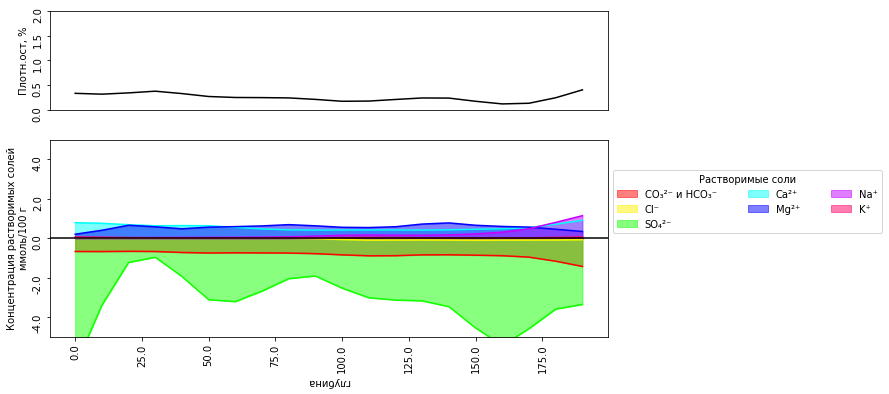

In [465]:
salt_profile(sample)

## Физика 

объемный вес

In [477]:
ob_ves = pd.read_csv('полевые данные общая/ready_data/объемный вес.csv')

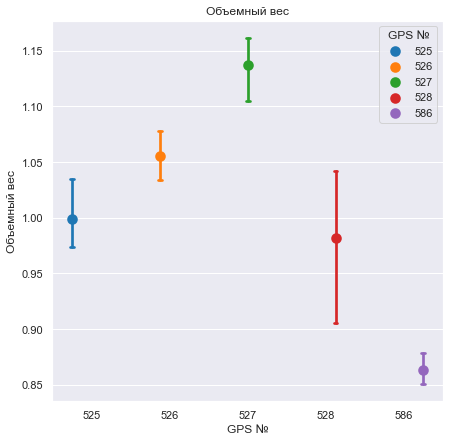

In [572]:
fig= plt.figure(figsize=(7,7))
ob_ves_plot = sns.pointplot(data = ob_ves,
        x = "GPS №",
        y = "Объемный вес",
        hue = "GPS №",
        palette = "tab10",
        scale = 1.2,
        ci = 95,
        dodge= 0.5,
        join = False,
        capsize = .05,
)
ob_ves_plot.set(title =  'Объемный вес')
plt.show()

гран состав

In [493]:
gran_sostav = pd.read_csv('полевые данные общая/ready_data/гранулометрический состав.csv')
sample = gran_sostav[gran_sostav["GPS №"] == 525]

In [546]:
def gransostav_plot(sample, plot_name):
    sns.set(rc={ 'figure.facecolor':'white'})
    small_labs = sample.columns[1:-3]
    big_labs = sample.columns[-3:-1]
    fig, ax  = plt.subplots(2,1, figsize = (4,8))

    ax[0].pie(x = sample[big_labs].values.reshape(-1),autopct="%.1f%%",explode=[0.05]  * 2 ,wedgeprops={'edgecolor': 'black'}, labels = big_labs, shadow=True)
    ax[1].pie(x = sample[small_labs].values.reshape(-1),autopct="%.1f%%",explode=[0.05]  * 6 , wedgeprops={'edgecolor': 'black'}, labels = small_labs, shadow=True)
    ax[0].set_title("Гранулометрический состав {}".format(plot_name))

    plt.show()


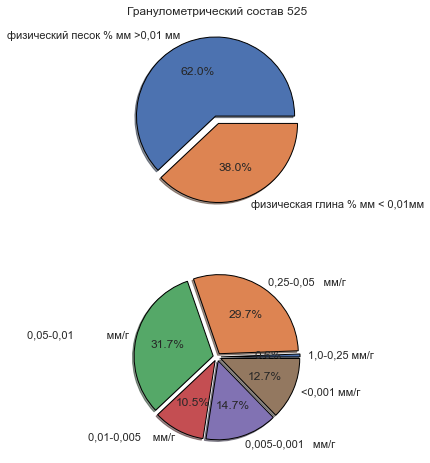

In [547]:
gransostav_plot(sample, '525')

Агрегатный состав и все с ним связанное 

In [609]:
agr_suhoe = pd.read_csv('полевые данные общая/ready_data/сухое просеивание.csv')

In [610]:
agr_suhoe_2019 = agr_suhoe[agr_suhoe['Год'] == 2019]
agr_suhoe_2020 = agr_suhoe[agr_suhoe['Год'] == 2020]

In [614]:
summa = agr_suhoe_2019[["Размер агрегатов, мм","Вес, г",'Тип обработки', "Поврторность", ]].groupby(['Тип обработки','Поврторность']).sum().reset_index()
summa.columns = ['Тип обработки','Поврторность','сумма агрегатов']
agr_suhoe_2019 = pd.merge(agr_suhoe_2019,summa, on =['Тип обработки','Поврторность'] )
agr_suhoe_2019['Содержание агрегатов'] = agr_suhoe_2019["Вес, г"]/agr_suhoe_2019['сумма агрегатов']
bad_agregates = agr_suhoe_2019[agr_suhoe_2019["Размер агрегатов, мм"].isin(['>10', '<0.25'])].groupby(['Тип обработки','Поврторность']).sum().reset_index()
good_agregates = agr_suhoe_2019[~agr_suhoe_2019["Размер агрегатов, мм"].isin(['>10', '<0.25'])].groupby(['Тип обработки','Поврторность']).sum().reset_index()

suhoe_features = pd.DataFrame()
good_agregates = good_agregates[['Тип обработки',"Поврторность","Содержание агрегатов"]]
good_agregates.columns = ['Тип обработки',"Поврторность",'содержание агрономически ценных агрегатов (0.25-10мм), %']



SyntaxError: invalid syntax (<ipython-input-614-3b48cf83eb02>, line 8)

In [615]:
good_agregates

,Тип обработки,Поврторность,"Вес, г",Год,GPS №,сумма агрегатов,Содержание агрегатов
0,ПП,[0],1698,14133,0.0,31094,0.382260
1,ПП,[1],1239,14133,0.0,20580,0.421429
2,ПП,[2],1555,14133,0.0,25816,0.421638
3,ПП,[3],1110,14133,0.0,23597,0.329279
4,ПП,[4],1239,14133,0.0,21147,0.410129
5,ТТ,[0],1340,14133,0.0,24346,0.385279
6,ТТ,[1],1293,14133,0.0,23457,0.385855
7,ТТ,[2],1957,14133,0.0,24395,0.561549
8,ТТ,[3],1379,14133,0.0,21077,0.457987
9,ТТ,[4],1601,14133,0.0,27678,0.404906


In [612]:
bad_agregates

,Тип обработки,Поврторность,"Вес, г",Год,GPS №,сумма агрегатов,Содержание агрегатов
0,ПП,[0],2744,4038,0.0,8884,0.617740
1,ПП,[1],1701,4038,0.0,5880,0.578571
2,ПП,[2],2133,4038,0.0,7376,0.578362
3,ПП,[3],2261,4038,0.0,6742,0.670721
4,ПП,[4],1782,4038,0.0,6042,0.589871
5,ТТ,[0],2138,4038,0.0,6956,0.614721
6,ТТ,[1],2058,4038,0.0,6702,0.614145
7,ТТ,[2],1528,4038,0.0,6970,0.438451
8,ТТ,[3],1632,4038,0.0,6022,0.542013
9,ТТ,[4],2353,4038,0.0,7908,0.595094


In [613]:
good_agregates

,Тип обработки,Поврторность,"Вес, г",Год,GPS №,сумма агрегатов,Содержание агрегатов
0,ПП,[0],1698,14133,0.0,31094,0.382260
1,ПП,[1],1239,14133,0.0,20580,0.421429
2,ПП,[2],1555,14133,0.0,25816,0.421638
3,ПП,[3],1110,14133,0.0,23597,0.329279
4,ПП,[4],1239,14133,0.0,21147,0.410129
5,ТТ,[0],1340,14133,0.0,24346,0.385279
6,ТТ,[1],1293,14133,0.0,23457,0.385855
7,ТТ,[2],1957,14133,0.0,24395,0.561549
8,ТТ,[3],1379,14133,0.0,21077,0.457987
9,ТТ,[4],1601,14133,0.0,27678,0.404906
